In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch_optimizer as optim
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time

from model import ConvNet_Shallow_Single as ConvNet_SS
from model import ConvNet 


import sys

import fasttext.CustomDataset as CustomDataset

[nltk_data] Downloading package punkt to /nfs4/ushashi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))
        

LEARNINGRATE = 3e-3
GAMMA = 0.98

BATCHSIZE = 1024
NUMEPOCHS = 20


dset = CustomDataset.get_dataset('data/train.csv')
tset = CustomDataset.get_dataset('data/test.csv')

print('''
0 - World
1 - Sports
2 - Business
3 - Sci/Tech
''')

### TRAIN VAL SPLIT

NUM_DATA_POINTS = len(dset)

indices = list(range(NUM_DATA_POINTS))
split = int(np.floor(0.2 * NUM_DATA_POINTS))
np.random.shuffle(indices)

print(indices[0])


train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_points = len(train_indices)
val_points = len(val_indices)

train_loader = torch.utils.data.DataLoader(dset, batch_size = BATCHSIZE, 
                                           sampler=train_sampler, num_workers=4)
validation_loader = torch.utils.data.DataLoader(dset, batch_size = BATCHSIZE,
                                                sampler=valid_sampler, num_workers=4)
test_loader = torch.utils.data.DataLoader(tset, batch_size = BATCHSIZE,
                                                num_workers=4)

print("Printing Train + Val Number of Documents Found")
print(NUM_DATA_POINTS)

/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/nfs4/ushashi/anaconda3/envs/gp


0 - World
1 - Sports
2 - Business
3 - Sci/Tech

23848
Printing Train + Val Number of Documents Found
120000


In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ConvNet(True, WINDOW=3)
print('Running on',device)
print('Building Master model..')
model.to(device)
print('Model Built.')

FILE = 'fasttext/weights_2/Model_quicksave5.pt'

model.load_state_dict(torch.load(FILE,map_location='cuda:0'))
model.eval()

print('Initializing optimizer and scheduler..')

criterion = torch.nn.NLLLoss()
optimizer = optim.RAdam(model.parameters(), lr = LEARNINGRATE)             # OR RAdam/DiffGrad/etc
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = GAMMA)

print('Optimizer and scheduler initialized.')


print('Printing Parameters')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        #print(param.shape)
print('---Printing Parameters Finished!---')

Running on cuda:0
Building Master model..
Model Built.
Initializing optimizer and scheduler..
Optimizer and scheduler initialized.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
---Printing Parameters Finished!---


In [12]:
corr = 0.0
with torch.no_grad():
  for ib,sample in enumerate(test_loader):

    data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
    data_output = torch.as_tensor(sample['class'][:,0])

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy : {:.2f}%'.format(corr*100.0/len(tset)))

Test Accuracy : 91.12%


In [13]:
from keras import backend as K
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D, Dropout
from keras.models import Model
import tensorflow as tf
import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

print(K.image_data_format())

with tf.device('/GPU:0'):
    inp = Input((None,300,1))
    x = Conv2D(1024,(3,300),activation='relu', name='conv1')(inp)
    x = GlobalMaxPool2D('channels_last')(x)
    x = Dense(256,name='fc1',activation='relu')(x)
    z = Dropout(0.25)(x)
    ou = Dense(32,name='fc2',activation='relu')(z)
    ou = Dropout(0.3)(ou)
    out = Dense(4,name='fc3')(ou)
    outz = Dropout(0.2)(out)
    k_model = Model(inp, outz)


trained_weights = model.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()

channels_last
['conv1' 'fc1' 'fc2' 'fc3']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 1024)     922624    
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1024)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               262400    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 32)                8224      
_________________________________________________________________
dropout_5 (Dropout)          (None

In [14]:
method = ("lrp.z",{},"LRP-Z")
         
analyzer = innvestigate.create_analyzer(method[0], k_model,**method[1]) #neuron_selection_mode="index",  

'''
for i in range(train_points):
 
    index = train_indices[i]
    x = dset[index]['matrix']
    x = x.reshape((1, -1, 300,1)).numpy()    
    analyzis[i] = np.zeros(x.shape[1])
    
    a = np.squeeze(analyzer.analyze(x))
    a = np.sum(a, axis=1)
    analyzis[i] = a   
'''

"\nfor i in range(train_points):\n \n    index = train_indices[i]\n    x = dset[index]['matrix']\n    x = x.reshape((1, -1, 300,1)).numpy()    \n    analyzis[i] = np.zeros(x.shape[1])\n    \n    a = np.squeeze(analyzer.analyze(x))\n    a = np.sum(a, axis=1)\n    analyzis[i] = a   \n"

In [7]:
import time

top_n = 3
min_val_loss = float('inf')

loss_values_train = []
loss_values_val = []

print('Batch Size = ',BATCHSIZE)

for epoch in range(1,NUMEPOCHS+1):
    start_time = time.time()
    
    model.train()
    runloss = 0.0
    tacc = 0
    ##################
    #print('At start')
    #time.sleep(10)
    if epoch%2 == 1:
        mode = 'Forced Epoch'
        
        for layer in unique_layers:
            weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
            biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
            if 'bn' in layer:
                running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
                running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
                W = [weights, biases, running_mean, running_var]
            elif 'fc' in layer:
                biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
                W = [weights.T, biases]
            else:
                W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
            k_model.get_layer(layer).set_weights(W)
        
        ############
        #print('After model load')
        #time.sleep(10)
        for ib,sample in enumerate(train_loader):
            
            data_input = sample['matrix'][:,None,:,:].numpy()
            data_output = sample['class'][:,0].numpy()

            for j in range(BATCHSIZE):
                #index = train_indices[BATCHSIZE*ib+j]
                #sample = dset[index]
                try:
                    data = data_input[j]
                except IndexError as error:
                    break
                
                data = data.reshape((1, -1, 300,1))    
                analysis = np.zeros(data.shape[1])
                
                a = np.squeeze(analyzer.analyze(data))
                a = np.sum(a, axis=1)
                
                order = np.argsort(a)[::-1]
                for k in order[:top_n]:
                    data_input[j,:,k,:] = np.zeros((1,1,300)) 
            
            data_input = torch.as_tensor(data_input)
            data_output = torch.as_tensor(data_output)
            
            data_input = data_input.to(device, dtype=torch.float)  #, dtype=torch.float
            data_output = data_output.to(device, dtype=torch.long)    #, dtype=torch.long

            output = model(data_input) 
            _, preds = torch.max(output, 1)

            loss = criterion(output, data_output)
            runloss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            runloss += loss.item() * data_input.size(0)
            tacc += (torch.sum(preds == data_output.data)).data.item()

        runloss /= (train_points)
        tacc = tacc*100.0/ (train_points)

        loss_values_train.append(runloss)
        
        
    if epoch%2 == 0:    
        mode = 'Unforced Epoch'
        for ib,sample in enumerate(train_loader):

            data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
            data_output = torch.as_tensor(sample['class'][:,0])

            data_input = data_input.to(device, dtype=torch.float)  #, dtype=torch.float
            data_output = data_output.to(device, dtype=torch.long)    #, dtype=torch.long

            output = model(data_input) 
            _, preds = torch.max(output, 1)

            loss = criterion(output, data_output)
            runloss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            runloss += loss.item() * data_input.size(0)
            tacc += (torch.sum(preds == data_output.data)).data.item()

        runloss /= train_points 
        tacc = tacc*100.0/ train_points

        loss_values_train.append(runloss)
    
    model.eval()

    val_loss = 0
    corr = 0
    
    with torch.no_grad():
        for ib,sample in enumerate(validation_loader):
            
            data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
            data_output = torch.as_tensor(sample['class'][:,0])

            data_input = data_input.to(device, dtype=torch.float)
            data_output = data_output.to(device, dtype=torch.long)

            output = model(data_input)
            _, preds = torch.max(output,dim=1)
            
            loss = criterion(output, data_output)
            val_loss += loss.item()* data_input.size(0)
            corr += (torch.sum(preds == data_output.data)).data.item()
            
    val_loss /= val_points
    corr = corr*100.0/val_points
    loss_values_val.append(val_loss)

    if val_loss <= min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'fasttext/feedback_NEG/Model_best_val_quicksave.pt')

    
    stop_time = time.time()
    time_el = int(stop_time-start_time)
    

    print('epoch [{}/{}] '.format(epoch, NUMEPOCHS)+mode+' loss:{:.7f}, train acc:{:.4f}, val loss:{:.7f}, val acc:{:.4f} in {}h {}m {}s'.format(
                                                                                runloss, tacc, val_loss, corr,
                                                                                time_el//3600,
                                                                                (time_el%3600)//60,
                                                                               time_el%60))
    
    torch.save(model.state_dict(), 'fasttext/feedback_NEG/Model_quicksave'+str(epoch)+'.pt')
    scheduler.step()
    

Batch Size =  1024
epoch [1/20] Forced Epoch loss:0.5269028, train acc:79.7604, val loss:0.2690310, val acc:91.3208 in 0h 3m 50s
epoch [2/20] Unforced Epoch loss:0.2600972, train acc:89.2094, val loss:0.2544317, val acc:91.6625 in 0h 0m 43s
epoch [3/20] Forced Epoch loss:0.5010516, train acc:80.8135, val loss:0.2616703, val acc:91.2208 in 0h 3m 31s
epoch [4/20] Unforced Epoch loss:0.2655985, train acc:89.1427, val loss:0.2815978, val acc:90.9000 in 0h 0m 46s
epoch [5/20] Forced Epoch loss:0.4783108, train acc:81.7531, val loss:0.2712357, val acc:91.1625 in 0h 3m 39s
epoch [6/20] Unforced Epoch loss:0.2445533, train acc:89.7396, val loss:0.2689807, val acc:91.9708 in 0h 0m 53s
epoch [7/20] Forced Epoch loss:0.4491534, train acc:82.5208, val loss:0.3193059, val acc:89.6167 in 0h 3m 23s
epoch [8/20] Unforced Epoch loss:0.2229130, train acc:90.2313, val loss:0.2849990, val acc:91.9375 in 0h 0m 50s
epoch [9/20] Forced Epoch loss:0.4419384, train acc:83.0052, val loss:0.3001902, val acc:90.9

"\nplt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')\nplt.plot(np.array(loss_values_train), 'b')\nplt.plot(np.array(loss_values_val), 'r')\nplt.legend(['Train','Val'])\nplt.grid(True)\nplt.xlabel('Epochs')\nplt.ylabel('Loss')\nplt.savefig('fasttext/train_curve_s4-2.png')\n"

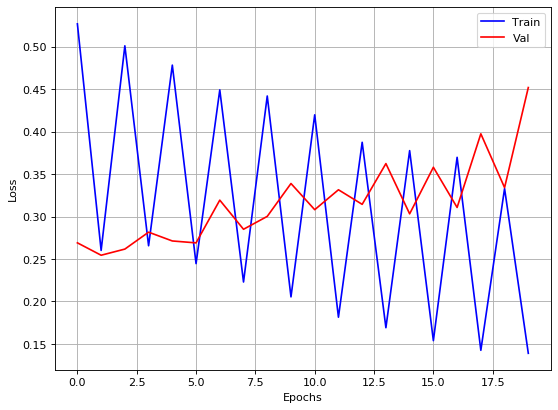

In [8]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.array(loss_values_train), 'b')
plt.plot(np.array(loss_values_val), 'r')
plt.legend(['Train','Val'])
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('fasttext/train_curve_feedback.png')
plt.show()

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))
        

LEARNINGRATE = 2e-4
GAMMA = 0.8

BATCHSIZE = 1024
NUMEPOCHS = 3


dset = CustomDataset.get_dataset('data/train.csv')
tset = CustomDataset.get_dataset('data/test.csv')

print('''
0 - World
1 - Sports
2 - Business
3 - Sci/Tech
''')

### TRAIN VAL SPLIT

NUM_DATA_POINTS = len(dset)

indices = list(range(NUM_DATA_POINTS))
split = int(np.floor(0.2 * NUM_DATA_POINTS))
np.random.shuffle(indices)

print(indices[0])


train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_points = len(train_indices)
val_points = len(val_indices)

train_loader = torch.utils.data.DataLoader(dset, batch_size = BATCHSIZE, 
                                           sampler=train_sampler, num_workers=4)
validation_loader = torch.utils.data.DataLoader(dset, batch_size = BATCHSIZE,
                                                sampler=valid_sampler, num_workers=4)
test_loader = torch.utils.data.DataLoader(tset, batch_size = BATCHSIZE,
                                                num_workers=4)

print("Printing Train + Val Number of Documents Found")
print(NUM_DATA_POINTS)


0 - World
1 - Sports
2 - Business
3 - Sci/Tech

54230
Printing Train + Val Number of Documents Found
120000


In [16]:
import time

top_n = 4
min_val_loss = float('inf')

loss_values_train = []
loss_values_val = []

print('Batch Size = ',BATCHSIZE)

for epoch in range(1,NUMEPOCHS+1):
    start_time = time.time()
    
    model.train()
    runloss = 0.0
    tacc = 0
    ##################
    #print('At start')
    #time.sleep(10)
        
    for layer in unique_layers:
        weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        if 'bn' in layer:
            running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
            running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
            W = [weights, biases, running_mean, running_var]
        elif 'fc' in layer:
            biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
            W = [weights.T, biases]
        else:
            W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
        k_model.get_layer(layer).set_weights(W)

    ############
    #print('After model load')
    #time.sleep(10)
    for ib,sample in enumerate(train_loader):

        data_input = sample['matrix'][:,None,:,:].numpy()
        data_output = sample['class'][:,0].numpy()

        for j in range(BATCHSIZE):
            #index = train_indices[BATCHSIZE*ib+j]
            #sample = dset[index]
            try:
                data = data_input[j]
            except IndexError as error:
                break

            data = data.reshape((1, -1, 300,1))    
            analysis = np.zeros(data.shape[1])

            a = np.squeeze(analyzer.analyze(data))
            a = np.sum(a, axis=1)

            order = np.argsort(a)[::-1]
            for k in order[:top_n]:
                data_input[j,:,k,:] = np.zeros((1,1,300)) 

        data_input = torch.as_tensor(data_input)
        data_output = torch.as_tensor(data_output)

        data_input = data_input.to(device, dtype=torch.float)  #, dtype=torch.float
        data_output = data_output.to(device, dtype=torch.long)    #, dtype=torch.long

        output = model(data_input) 
        _, preds = torch.max(output, 1)

        loss = criterion(output, data_output)
        runloss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        runloss += loss.item() * data_input.size(0)
        tacc += (torch.sum(preds == data_output.data)).data.item()

    runloss /= (train_points)
    tacc = tacc*100.0/ (train_points)

    loss_values_train.append(runloss)
        
        
    model.eval()

    val_loss = 0
    corr = 0
    
    with torch.no_grad():
        for ib,sample in enumerate(validation_loader):
            
            data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
            data_output = torch.as_tensor(sample['class'][:,0])

            data_input = data_input.to(device, dtype=torch.float)
            data_output = data_output.to(device, dtype=torch.long)

            output = model(data_input)
            _, preds = torch.max(output,dim=1)
            
            loss = criterion(output, data_output)
            val_loss += loss.item()* data_input.size(0)
            corr += (torch.sum(preds == data_output.data)).data.item()
            
    val_loss /= val_points
    corr = corr*100.0/val_points
    loss_values_val.append(val_loss)

    if val_loss <= min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'fasttext/feedback-v2_NEG/Model_best_val_quicksave.pt')

    
    stop_time = time.time()
    time_el = int(stop_time-start_time)
    

    print('epoch [{}/{}] '.format(epoch, NUMEPOCHS)+mode+' loss:{:.7f}, train acc:{:.4f}, val loss:{:.7f}, val acc:{:.4f} in {}h {}m {}s'.format(
                                                                                runloss, tacc, val_loss, corr,
                                                                                time_el//3600,
                                                                                (time_el%3600)//60,
                                                                               time_el%60))
    
    torch.save(model.state_dict(), 'fasttext/feedback-v2_NEG/Model_quicksave'+str(epoch)+'.pt')
    scheduler.step()
    

Batch Size =  1024
epoch [1/3] Unforced Epoch loss:0.5690066, train acc:77.6990, val loss:0.1782762, val acc:94.2042 in 0h 4m 4s
epoch [2/3] Unforced Epoch loss:0.5433337, train acc:78.5771, val loss:0.1775615, val acc:94.2375 in 0h 4m 2s
epoch [3/3] Unforced Epoch loss:0.5296031, train acc:78.9833, val loss:0.1736264, val acc:94.3917 in 0h 4m 3s


In [17]:
corr = 0.0
with torch.no_grad():
  for ib,sample in enumerate(test_loader):

    data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
    data_output = torch.as_tensor(sample['class'][:,0])

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy: {:.2f}%'.format(corr*100.0/len(tset)))

Test Accuracy: 92.14%
